postage_stamps
--------------

This notebook produces figure 1 of the review Krumholz, McKee, & Bland-Hawthorn (2019, ARA&A, submitted). Unlike all the other notebooks in this archive, the raw data that the notebook processes in order to produce the figure are NOT included in the repository for reasons of size. Instead, the notebook will download the images automatically and cache them when run. *Note that the data files that will be downloaded by this process are >1 GB in size.*

In addition to the standard dependencies of all notebooks in this repository, this notebook requires [Pillow](https://python-pillow.org/).

In [1]:
%matplotlib inline

In [2]:
# Import libraries; note that we will be using the Pillow library, so that
# needs to be installed, but we won't import it directly because we'll call
# it through matplotlib.imread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import astropy.units as u
import astropy.io.fits as fits
import os.path as osp
from scipy.ndimage.interpolation import rotate, shift
from astropy.coordinates import SkyCoord

In [3]:
# A little utility for downloading files
def download(url, fname):
    print("Attempting to fetch {:s} image file from {:s}...".format(fname, url))
    try:
        # Python 3 method
        import urllib.request as req
        req.urlretrieve(url, osp.join("data", fname))
    except:
        # Pyton 2 method
        import urllib2
        urlhandle = urllib2.urlopen(url)
        with open(osp.join("data", fname), "wb") as fhandle:
            fhandle.write(urlhandle.read())
    print("Success!")

In [4]:
# Physical size of all images
sz = 3*u.pc

In [5]:
# Parameters for the ONC
dist_onc = 0.389*u.kpc         # Distance to ONC, from Kounkel+ 2018
ra_th1c  = 83.81859895833333   # RA of theta 1 Ori C, in degrees
dec_th1c = -5.390235722222223  # DEC of theta 1 Ori C, in degrees

In [6]:
# Read Orion imaging
try:
    bdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_b_v1_drz.fits'))
except IOError:
    download("https://archive.stsci.edu/pub/hlsp/orion/images/acs/hlsp_orion_hst_acs_colorimage_b_v1_drz.fits",
             "hlsp_orion_hst_acs_colorimage_b_v1_drz.fits")
    bdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_b_v1_drz.fits'))
try:
    gdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_g_v1_drz.fits'))
except IOError:
    download("https://archive.stsci.edu/pub/hlsp/orion/images/acs/hlsp_orion_hst_acs_colorimage_g_v1_drz.fits",
             "hlsp_orion_hst_acs_colorimage_g_v1_drz.fits")
    gdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_g_v1_drz.fits'))
try:
    rdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_r_v1_drz.fits'))
except IOError:
    download("https://archive.stsci.edu/pub/hlsp/orion/images/acs/hlsp_orion_hst_acs_colorimage_r_v1_drz.fits",
             "hlsp_orion_hst_acs_colorimage_r_v1_drz.fits")
    rdata = fits.open(osp.join('data', 'hlsp_orion_hst_acs_colorimage_r_v1_drz.fits'))

In [7]:
# Reference pixel location and pixel scale
ra_ref = bdata[0].header['CRVAL1']
dec_ref = bdata[0].header['CRVAL2']
ra_per_pix = bdata[0].header['CD1_1']  # Neglect the truly tiny roll of the field
dec_per_pix = bdata[0].header['CD2_2']

# Position of theta 1 c
x_pix_ref = bdata[0].header['CRPIX1']
y_pix_ref = bdata[0].header['CRPIX2']
x_th1c = (ra_th1c - ra_ref) / ra_per_pix + x_pix_ref
y_th1c = (dec_th1c - dec_ref) / dec_per_pix + y_pix_ref

# Calculate pixel range corresponding to desired field of view
x_phys_per_pix = ra_per_pix/180.*np.pi*dist_onc
y_phys_per_pix = dec_per_pix/180.*np.pi*dist_onc / np.cos(dec_ref*np.pi/180)
x_size_pix = np.abs(sz / x_phys_per_pix).to('')
y_size_pix = np.abs(sz / y_phys_per_pix).to('')
x_pix_lim = [ int(round(float(x_th1c-x_size_pix/2))), int(round(float(x_th1c+x_size_pix/2)))]
y_pix_lim = [ int(round(float(y_th1c-y_size_pix/2))), int(round(float(y_th1c+y_size_pix/2)))]

# Clip pixel range if necessary
x_lim = np.copy(x_pix_lim)
y_lim = np.copy(y_pix_lim)
if x_lim[0] < 0: 
    x_lim[0] = 0
    xoff = -x_pix_lim[0]
else:
    xoff = 0
if x_lim[1] >= rdata[0].shape[1]:
    x_lim[1] = rdata[0].shape[1]-1
if y_lim[0] < 0: 
    y_lim[0] = 0
    yoff = -y_pix_lim[0]
else:
    yoff = 0
if y_lim[1] >= rdata[0].shape[0]: 
    y_lim[1] = rdata[0].shape[0]-1

# Create output data holder
onc_img = np.zeros((y_pix_lim[1]-y_pix_lim[0],
                    x_pix_lim[1]-x_pix_lim[0],
                    3), dtype='uint8')

# Cut out desired pixel range
onc_img[yoff:yoff+y_lim[1]-y_lim[0],
        xoff:xoff+x_lim[1]-x_lim[0],
        0] = rdata[0].data[y_lim[0]:y_lim[1], 
                           x_lim[0]:x_lim[1]]
onc_img[yoff:yoff+y_lim[1]-y_lim[0],
        xoff:xoff+x_lim[1]-x_lim[0],
        1] = gdata[0].data[y_lim[0]:y_lim[1], 
                           x_lim[0]:x_lim[1]]
onc_img[yoff:yoff+y_lim[1]-y_lim[0],
        xoff:xoff+x_lim[1]-x_lim[0],
        2] = bdata[0].data[y_lim[0]:y_lim[1], 
                           x_lim[0]:x_lim[1]]

# Figure out limits in RA and DEC
onc_ra_lim = ra_th1c + 180/np.pi*sz/dist_onc*np.array([-0.5,0.5]) / np.cos(dec_ref*np.pi/180)
onc_dec_lim = dec_th1c + 180/np.pi*sz/dist_onc*np.array([-0.5,0.5])

In [8]:
# Function that processes tif images from the HST archive into
# something sort of reasonable for science; this takes as input
# a file name and some metadata, and returns as output an image
# that has been cropped to a specified physical field of view and oriented
# so North is up, along with the RA and DEC limits on the field
def process_image(fname, rot, fov, coord, dist, sz, ctr=None):
    """
    Process an image file from www.spacetelescope.org into something
    that is sort-of usable for science, at least for illustrations
    
    Parameters
        fname : string
            name of file to be processes
        rot : float
            rotation angle of the North vector, in degrees, with positive
            indicating North is counterclockwise from vertical
        fov : float
            field of view of the image, in degrees
        coord : SkyCoord
            coordinates of image center, as an astropy SkyCoord object
        dist : float
            distance to field; units are arbitrary, but must be the same as the
            units used to specify sz
        sz : float
            desired physical size of final image; same units as dist
        ctr : array(2)
            location in the field to center the cutout region around, specified
            in axis coordinates (i.e., [0.3, 0.9] is a point that is 30% of the
            way across the image left to right, 90% of the way from the bottom
            to the top; defaults to the center of the original image, [0.5, 0.5]
           
    Returns
        img : array
            final image
        ra_lim : array
            lower and upper limits on RA in final image
        dec_lim : array
            lower and upper limit on DEC in final image
    """
    
    # Read the image data
    data = plt.imread(fname)
    
    # Re-center the image if requested
    if ctr is not None:
        data = shift(data, [(ctr[1]-0.5)*data.shape[0],
                            (0.5-ctr[0])*data.shape[1],
                            0],
                     mode = 'constant')
    
    # Rotate the image so that North points up; the reshape = False keeps the pixel scale the same
    data_rot = rotate(data, -rot, reshape=False)
    
    # Get image pixel scale
    deg_per_pix = fov / data_rot.shape[1]

    # Calculate pixel range corresponding to desired field of view
    phys_per_pix = deg_per_pix/180.*np.pi*dist
    size_pix = float(np.abs(sz / phys_per_pix))
    ctrpix = [data_rot.shape[1]/2, data_rot.shape[0]/2]
    x_pix_lim = np.array(
        np.round(ctrpix[0] + size_pix/2 * np.array([-1,1])),
        dtype='int')
    y_pix_lim = np.array(
        np.round(ctrpix[1] + size_pix/2 * np.array([-1,1])),
        dtype='int')
    
    # Clip pixel range if necessary
    x_lim = np.copy(x_pix_lim)
    y_lim = np.copy(y_pix_lim)
    if x_lim[0] < 0: 
        x_lim[0] = 0
        xoff = -x_pix_lim[0]
    else:
        xoff = 0
    if x_lim[1] >= data.shape[1]:
        x_lim[1] = data.shape[1]-1
    if y_lim[0] < 0: 
        y_lim[0] = 0
        yoff = -y_pix_lim[0]
    else:
        yoff = 0
    if y_lim[1] >= data.shape[0]: 
        y_lim[1] = data.shape[0]-1

    # Create output data holder
    img = np.zeros((y_pix_lim[1]-y_pix_lim[0],
                    x_pix_lim[1]-x_pix_lim[0],
                    data.shape[2]), dtype=data.dtype)

    # Cut out desired pixel range
    img[yoff:yoff+y_lim[1]-y_lim[0],
        xoff:xoff+x_lim[1]-x_lim[0],
        :] \
        = data_rot[y_lim[0]:y_lim[1], 
                   x_lim[0]:x_lim[1],
                   :]

    # Figure out range in RA and DEC
    ra_lim = coord.ra + 180*u.deg/np.pi*sz/dist*np.array([0.5,-0.5]) \
                / np.cos(coord.dec*np.pi/180)
    dec_lim = coord.dec + 180*u.deg/np.pi*sz/dist*np.array([-0.5,0.5])
    
    # Return
    return img, ra_lim, dec_lim

In [9]:
# Arches
# Image from https://www.spacetelescope.org/images/potw1521a/
# Distance is from Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529, assuming same as distance to GC
arches_coord = SkyCoord(ra="17h45m50.45s", dec="-28d49m17.99s")
dist_arches = 8.2e3 * u.pc
try:
    arches_img, arches_ra, arches_dec \
        = process_image(osp.join('data', 'arches.tif'),
                        45., 2.29/60., arches_coord,
                        float((dist_arches/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://www.spacetelescope.org/static/archives/images/original/potw1521a.tif", "arches.tif")
    arches_img, arches_ra, arches_dec \
        = process_image(osp.join('data', 'arches.tif'),
                        45., 2.29/60., arches_coord,
                        float((dist_arches/u.pc).to('')), float((sz/u.pc).to('')))

In [10]:
# NGC 265
# Image from https://spacetelescope.org/images/heic0603b/
# Distance from the SMC distance given by Tully et al., 2016, AJ, 152, 50
ngc265_coord = SkyCoord(ra="0h47m5.22s", dec="-73d29m28.55s")
dist_ngc265 = 60e3*u.pc
try:
    ngc265_img, ngc265_ra, ngc265_dec \
        = process_image(osp.join('data', 'ngc265.tif'),
                        -26., 1.41/60., ngc265_coord,
                        float((dist_ngc265/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://spacetelescope.org/static/archives/images/original/heic0603b.tif", "ngc265.tif")
    ngc265_img, ngc265_ra, ngc265_dec \
        = process_image(osp.join('data', 'ngc265.tif'),
                        -26., 1.41/60., ngc265_coord,
                        float((dist_ugc265/u.pc).to('')), float((sz/u.pc).to('')))

In [11]:
# Hyades
# Image from https://www.spacetelescope.org/images/heic1309c/
# Distance from McArthur et al., 2011, AJ, 141, 172
hyades_coord = SkyCoord(ra="4h28m52.00s", dec="15d22m21.69s")
dist_hyades = 47.5*u.pc
try:
    hyades_img, hyades_ra, hyades_dec \
        = process_image(osp.join('data', 'hyades.tif'), -0.4, 431.51/60., hyades_coord,
                        float((dist_hyades/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://www.spacetelescope.org/static/archives/images/original/heic1309c.tif", "hyades.tif")
    hyades_img, hyades_ra, hyades_dec \
        = process_image(osp.join('data', 'hyades.tif'), -0.4, 431.51/60., hyades_coord,
                        float((dist_hyades/u.pc).to('')), float((sz/u.pc).to('')))    

In [12]:
# Collinder261
# Image from https://www.eso.org/public/images/eso0715a/
# Distance from Kharchenko+ 2013 catalog
c261_coord = SkyCoord(ra="12h37m56.93s", dec="-68d22m1.43s")
dist_c261 = 2.683e3*u.pc
try:
    c261_img, c261_ra, c261_dec \
        = process_image(osp.join('data', 'collinder261.tif'),
                        -5.8, 29.91/60., c261_coord,
                        float((dist_c261/u.pc).to('')), float((sz/u.pc).to('')),
                        ctr=[0.5,0.67])
except IOError:
    download("https://www.eso.org/public/archives/images/original/eso0715a.tif", "collinder261.tif")
    c261_img, c261_ra, c261_dec \
        = process_image(osp.join('data', 'collinder261.tif'),
                        -5.8, 29.91/60., c261_coord,
                        float((dist_c261/u.pc).to('')), float((sz/u.pc).to('')),
                        ctr=[0.5,0.67])

In [13]:
# NGC 6535
# Image from https://www.spacetelescope.org/images/potw1452a/
# Distance from Baumgardt & Hilker, 2018, MNRAS, 478, 1520
ngc6535_coord = SkyCoord(ra="18h3m50.40s", dec="0d17m43.96s")
dist_ngc6535 = 6.5e3*u.pc
try:
    ngc6535_img, ngc6535_ra, ngc6535_dec \
        = process_image(osp.join('data', 'ngc6535.tif'),
                        94., 3.31/60., ngc6535_coord,
                        float((dist_ngc6535/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://www.spacetelescope.org/static/archives/images/original/potw1452a.tif", "ngc6535.tif")
    ngc6535_img, ngc6535_ra, ngc6535_dec \
        = process_image(osp.join('data', 'ngc6535.tif'),
                        94., 3.31/60., ngc6535_coord,
                        float((dist_ngc6535/u.pc).to('')), float((sz/u.pc).to('')))

In [14]:
# 47 Tuc
# Image from https://spacetelescope.org/images/heic1510a/
# Distance from Baumgardt & Hilker, 2018, MNRAS, 478, 1520
tuc_coord = SkyCoord(ra="0h24m6.67s", dec="-72d4m2.74s")
dist_47tuc = 4.4e3*u.pc
try:
    tuc_img, tuc_ra, tuc_dec \
        = process_image(osp.join('data', '47tuc.tif'),
                        14.8, 2.80/60., tuc_coord,
                        float((dist_47tuc/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://spacetelescope.org/static/archives/images/original/heic1510a.tif", "47tuc.tif")
    tuc_img, tuc_ra, tuc_dec \
        = process_image(osp.join('data', '47tuc.tif'),
                        14.8, 2.80/60., tuc_coord,
                        float((dist_47tuc/u.pc).to('')), float((sz/u.pc).to('')))

In [15]:
# NGC 1252
# Image from WEBDA database, https://www.univie.ac.at/webda/cgi-bin/ocl_page.cgi?dirname=ngc1252
# Distance from same source, though in fact it is meaningless because stars
# are not actually at the same distance
ngc1252_coord = SkyCoord(ra="03h10m49s", dec="-57d46m00s")
dist_ngc1252 = 657*u.pc
try:
    ngc1252_img, ngc1252_ra, ngc1252_dec \
        = process_image(osp.join('data', 'ngc1252.png'),
                        0, 14./60., ngc1252_coord,
                        float((dist_ngc1252/u.pc).to('')), float((sz/u.pc).to('')))
except IOError:
    download("https://www.univie.ac.at/webda/dss/ngc1252.png", "ngc1252.png")
    ngc1252_img, ngc1252_ra, ngc1252_dec \
        = process_image(osp.join('data', 'ngc1252.png'),
                        0, 14./60., ngc1252_coord,
                        float((dist_ngc1252/u.pc).to('')), float((sz/u.pc).to('')))

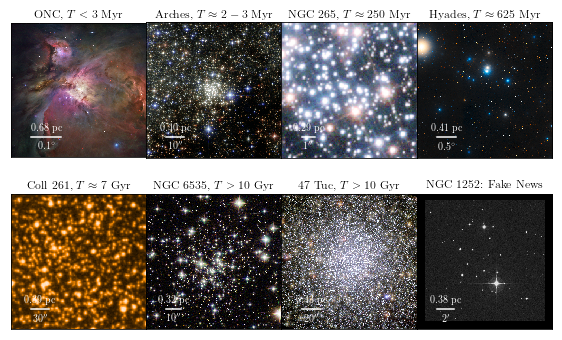

In [16]:
# Make composite image
plt.figure(1, figsize=(8,4.7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# ONC
ax = plt.subplot(2,4,1)
plt.imshow(onc_img, origin='lower', 
           extent=[onc_ra_lim[1]-ra_th1c, onc_ra_lim[0]-ra_th1c, 
                   onc_dec_lim[0]-dec_th1c, onc_dec_lim[1]-dec_th1c])
scalelen = 0.1*u.deg
dx = (scalelen/((onc_ra_lim[1]-onc_ra_lim[0])*u.deg)).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r'$0.1^\circ$', 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_onc.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title('ONC, $T < 3$ Myr')
plt.xticks([])
plt.yticks([])

# Arches
ax=plt.subplot(2,4,2)
plt.imshow(arches_img, 
           extent=[
               ((arches_ra[1]-arches_coord.ra)/u.arcsec).to(''), 
               ((arches_ra[0]-arches_coord.ra)/u.arcsec).to(''), 
               ((arches_dec[0]-arches_coord.dec)/u.arcsec).to(''),
               ((arches_dec[1]-arches_coord.dec)/u.arcsec).to('')])
scalelen = 10*u.arcsec
dx = (scalelen/(arches_ra[0]-arches_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$10^{\prime\prime}$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_arches.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'Arches, $T \approx 2-3$ Myr')
plt.xticks([])
plt.yticks([])

# NGC265
ax=plt.subplot(2,4,3)
plt.imshow(ngc265_img, 
           extent=[
               ((ngc265_ra[1]-ngc265_coord.ra)/u.arcsec).to(''), 
               ((ngc265_ra[0]-ngc265_coord.ra)/u.arcsec).to(''), 
               ((ngc265_dec[0]-ngc265_coord.dec)/u.arcsec).to(''),
               ((ngc265_dec[1]-ngc265_coord.dec)/u.arcsec).to('')])
scalelen = 1*u.arcsec
dx = (scalelen/(ngc265_ra[0]-ngc265_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$1^{\prime\prime}$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_ngc265.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'NGC 265, $T \approx 250$ Myr')
plt.xticks([])
plt.yticks([])

# Hyades
ax=plt.subplot(2,4,4)
plt.imshow(hyades_img, 
           extent=[
               ((hyades_ra[1]-hyades_coord.ra)/u.deg).to(''), 
               ((hyades_ra[0]-hyades_coord.ra)/u.deg).to(''), 
               ((hyades_dec[0]-hyades_coord.dec)/u.deg).to(''),
               ((hyades_dec[1]-hyades_coord.dec)/u.deg).to('')])
scalelen = 0.5*u.deg
dx = (scalelen/(hyades_ra[0]-hyades_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$0.5^\circ$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_hyades.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'Hyades, $T \approx 625$ Myr')
plt.xticks([])
plt.yticks([])

# Collinder 261
ax=plt.subplot(2,4,5)
plt.imshow(c261_img, 
           extent=[
               ((c261_ra[1]-c261_coord.ra)/u.deg).to(''), 
               ((c261_ra[0]-c261_coord.ra)/u.deg).to(''), 
               ((c261_dec[0]-c261_coord.dec)/u.deg).to(''),
               ((c261_dec[1]-c261_coord.dec)/u.deg).to('')])
scalelen = 30*u.arcsec
dx = (scalelen/(c261_ra[0]-c261_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$30^{\prime\prime}$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_c261.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'Coll 261, $T \approx 7$ Gyr')
plt.xticks([])
plt.yticks([])


# NGC 6535
ax=plt.subplot(2,4,6)
plt.imshow(ngc6535_img, 
           extent=[
               ((ngc6535_ra[1]-ngc6535_coord.ra)/u.arcsec).to(''), 
               ((ngc6535_ra[0]-ngc6535_coord.ra)/u.arcsec).to(''), 
               ((ngc6535_dec[0]-ngc6535_coord.dec)/u.arcsec).to(''),
               ((ngc6535_dec[1]-ngc6535_coord.dec)/u.arcsec).to('')])
scalelen = 10*u.arcsec
dx = (scalelen/(ngc6535_ra[0]-ngc6535_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$10^{\prime\prime}$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_ngc6535.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'NGC 6535, $T > 10$ Gyr')
plt.xticks([])
plt.yticks([])

# 47 Tuc
ax=plt.subplot(2,4,7)
plt.imshow(tuc_img, 
           extent=[
               ((tuc_ra[1]-tuc_coord.ra)/u.arcsec).to(''), 
               ((tuc_ra[0]-tuc_coord.ra)/u.arcsec).to(''), 
               ((tuc_dec[0]-tuc_coord.dec)/u.arcsec).to(''),
               ((tuc_dec[1]-tuc_coord.dec)/u.arcsec).to('')])
scalelen = 20*u.arcsec
dx = (scalelen/(tuc_ra[0]-tuc_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$20^{\prime\prime}$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_47tuc.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'47 Tuc, $T > 10$ Gyr')
plt.xticks([])
plt.yticks([])

# NGC 1252
ax=plt.subplot(2,4,8)
plt.imshow(ngc1252_img, 
           extent=[
               ((ngc1252_ra[1]-ngc1252_coord.ra)/u.arcsec).to(''), 
               ((ngc1252_ra[0]-ngc1252_coord.ra)/u.arcsec).to(''), 
               ((ngc1252_dec[0]-ngc1252_coord.dec)/u.arcsec).to(''),
               ((ngc1252_dec[1]-ngc1252_coord.dec)/u.arcsec).to('')])
scalelen = 2*u.arcmin
dx = (scalelen/(ngc1252_ra[0]-ngc1252_ra[1])).to('')
plt.plot([0.15, 0.15+dx], [0.15, 0.15], transform=ax.transAxes, color='w')
plt.text(0.15+dx/2, 0.115, r"$2^\prime$", 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='top')
plt.text(0.15+dx/2, 0.185, r'{:4.2f}'.
         format(np.sin(scalelen.to('rad'))*dist_ngc1252.to('pc')), 
         transform=ax.transAxes, color='w',
         horizontalalignment='center', verticalalignment='bottom')
plt.title(r'NGC 1252: Fake News')
plt.xticks([])
plt.yticks([])


# Adjust spacing
plt.subplots_adjust(wspace=0, left=0.03, right=0.97, top=0.95, bottom=0.02)

# Save
plt.savefig(osp.join('figures', 'postage_stamps.pdf'))